In [11]:
import os
os.chdir('C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Codigo\\Modelling')

In [12]:
u=!pip freeze
instalados=str(u)

In [8]:
to_instalar=['os','pandas','matplotlib','statsmodels','numpy','seaborn','pingouin','pycaret','sklearn','scipy','openpyxl']

In [14]:
instalados=[x for x in to_instalar if x in  intalados ]
if len(set(to_instalar)-set(instalados))>0:
    !pip install -r requirements_pycaret.txt 

In [19]:
import pycaret

In [20]:
#!pip install -r requirements.txt --user
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from datetime import datetime
import math
import unicodedata
from unicodedata import normalize
import re
from dateutil.relativedelta import relativedelta
import pingouin
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import scipy
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
#import pycaret

c:\users\usuario\documents\entornos_virtuales\entornoprueba\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [21]:
ruta_madre="C:/Users/USUARIO/Documents/GitHub/Team_224/Proyecto"
ruta_insumos=os.path.join(ruta_madre, 'Insumos')
ruta_resultados=os.path.join(ruta_madre, 'Resultados')

## 1.0 Importando base de datos preprocesada

In [22]:
os.chdir(os.path.join(ruta_insumos,'preproccess_data'))
ruta_data_preproc=os.path.join(os.getcwd(),'data_agregada_preproccess.xlsx')
datos_preproc=pd.read_excel(ruta_data_preproc,index_col=0)


## 2.0 Featuring engineering 

Es empiza a hacer Feature engineering para evitar resultados raros

### 2.1 Deflactando los salarios

Debido al gran problema que genera la inflación a lo largo del tiempo, se prefiere usar cifras deflactadas, con lo cual, se utiliza la tabal abstraida del DANE para el IPC anual y se indexa hasta valores correspondientes al 2022. Es decir, la serie se deflacta y se pone todo en las mismas unidades monetarias en el mismo intervalo de tiempo

In [23]:
inflacion_variacion=pd.read_excel(os.path.join(os.getcwd(),'inflacion.xlsx'),index_col=0)
inflacion_variacion['inflacion']=inflacion_variacion['inflacion']/100+1
inflacion_variacion=inflacion_variacion[inflacion_variacion.index>=datos_preproc.year.min()]

In [24]:
inflacion_variacion=inflacion_variacion.sort_index(ascending=False).cumprod().reset_index()

In [25]:
datos_preproc=datos_preproc.merge(inflacion_variacion,on="year",how="left")
datos_preproc.inflacion.fillna(1,inplace=True)

In [26]:
datos_preproc['wage_deflacted']=datos_preproc['wage_imputed']*datos_preproc['inflacion']

### 2.2 Arreglando variables categoricas incompletas

In [41]:
datos_preproc['total_depedants']=datos_preproc['other_on_charge_person']+datos_preproc['children_amount']

In [42]:
datos_to_model=datos_preproc[['month','gender','is_special_population','any_disability','MUNICIPIO_DE_RESIDENCIA','home_type',
                             'education_level','PROFESION','marital_status','total_depedants','ESTRATO_SOCIAL','wage_deflacted',
                             'age','years_exp_current_role','request_attend_per_day']].copy()
datos_to_model['total_depedants']=datos_to_model['total_depedants'].astype('str')
datos_to_model['ESTRATO_SOCIAL']=datos_to_model['ESTRATO_SOCIAL'].astype('str')

In [43]:
datos_to_model.isna().sum()

month                       0
gender                      3
is_special_population       3
any_disability              3
MUNICIPIO_DE_RESIDENCIA     3
home_type                   3
education_level             3
PROFESION                  65
marital_status              3
total_depedants             0
ESTRATO_SOCIAL              0
wage_deflacted              0
age                         3
years_exp_current_role      3
request_attend_per_day      0
dtype: int64

Note que hay un total importante de NAs en algunos datos. sin embargo, no tenemos ninguna explicación de negocio para reemplazarlos por un numero, por lo que se pondrá como una nueva categoria

In [44]:
datos_to_model['gender']=datos_to_model['gender'].fillna('OTHER')
datos_to_model['is_special_population']=datos_to_model['is_special_population'].fillna('NO APLICA')
datos_to_model['any_disability']=datos_to_model['any_disability'].fillna('no_reported')
datos_to_model['MUNICIPIO_DE_RESIDENCIA']=datos_to_model['MUNICIPIO_DE_RESIDENCIA'].fillna('NO_REPORTADO')
datos_to_model['home_type']=datos_to_model['home_type'].fillna('OTHER')
datos_to_model['education_level']=datos_to_model['education_level'].fillna('OTHER')
datos_to_model['PROFESION']=datos_to_model['PROFESION'].fillna('OTHER')
datos_to_model['marital_status']=datos_to_model['marital_status'].fillna('OTHER')
datos_to_model['total_depedants']=datos_to_model['total_depedants'].fillna('OTHER')
datos_to_model['ESTRATO_SOCIAL']=datos_to_model['ESTRATO_SOCIAL'].fillna('OTHER')

El siguiente codigo presenta una transformacion de la variable edad, ya que al verlo respecto a la variable que mide la productividad, tiene una relacion no lineal. 

### 2.3 Agregadno polinomios de la edad

In [45]:
datos_to_model['age2']=datos_to_model['age']**2
datos_to_model['age3']=datos_to_model['age']**3
datos_to_model['age4']=datos_to_model['age']**4
datos_to_model['age5']=datos_to_model['age']**5

### 2.1 Regresion lineal sin ninguna modificacion

#### 2.1.1 Dividiendo en test y train set

Utilzamos un split de 70/30, sin embargo, solo usaremos este ejercicio con fin de tener una referencia de potenciales variables significativas. siendo el peor modelo y luego ir viendo como se comporta a futuro

In [57]:
y=datos_to_model[datos_to_model.columns[datos_to_model.columns=='request_attend_per_day']].copy()
X=datos_to_model[datos_to_model.columns[datos_to_model.columns!='request_attend_per_day']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [58]:
y_train

,request_attend_per_day
98,20.233333
697,66.322581
1536,66.354839
638,61.709677
1176,50.200000
...,...
715,0.548387
905,22.580645
1096,8.500000
235,3.366667


#### 2.1.2 Normalizando y transformando las variables

Normalizaremos salario y años de experiencia y todas las variables de edad

In [50]:
scaler = StandardScaler()

stand_xtrain=scaler.fit_transform(X_train[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']])
X_train[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']]=pd.DataFrame(stand_xtrain,columns=['wage_imputed','years_exp_current_role','age','age2','age3','age4','age5'],
                                                                                                 index=X_train.index)

stand_xtest=scaler.fit_transform(X_test[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']])
X_test[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']]=pd.DataFrame(stand_xtest,columns=['wage_imputed','years_exp_current_role','age','age2','age3','age4','age5'],
                                                                                                index=X_test.index)


c:\users\usuario\documents\entornos_virtuales\entornoprueba\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
c:\users\usuario\documents\entornos_virtuales\entornoprueba\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### 2.1.3 Aplicando un box cox a ver si se puede transformar

Se aplica una vez ya se crea el train set y el test set

In [74]:
from scipy import stats
ytrain_transformed, box_cox_lambda_ytrain = stats.boxcox(y_train.request_attend_per_day)
ytest_transformed, box_cox_lambda_ytest = stats.boxcox(y_test.request_attend_per_day)

Text(0.5, 1.0, 'Response variable test Original')

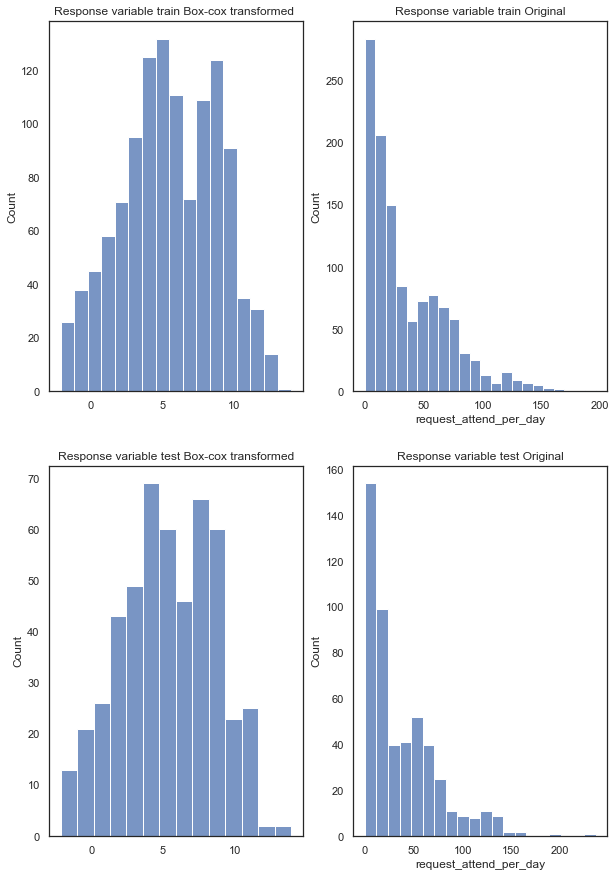

In [75]:
sns.set_theme()
sns.set_style('white')
plt.figure(figsize=(10,15))

plt.subplot(2,2,1)
sns.histplot(ytrain_transformed)
plt.title('Response variable train Box-cox transformed ')

plt.subplot(2,2,2)
sns.histplot(y_train.request_attend_per_day)
plt.title('Response variable train Original')

plt.subplot(2,2,3)
sns.histplot(ytest_transformed)
plt.title('Response variable test Box-cox transformed')

plt.subplot(2,2,4)
sns.histplot(y_test.request_attend_per_day)
plt.title('Response variable test Original')

Si es útil hacer la transformacion de box cox, ya que le disminuye el sesgo. por lo cual, deberíamos aplicarla.

In [99]:
#X_train_extended = sm.add_constant(X_train)
X_train_extended = X_train.copy()
X_train_extended['month']=X_train_extended.month.astype('category')
X_train_extended['gender']=X_train_extended.gender.astype('category')
X_train_extended['is_special_population']=X_train_extended.is_special_population.astype('category')
X_train_extended['any_disability']=X_train_extended.any_disability.astype('category')
X_train_extended['MUNICIPIO_DE_RESIDENCIA']=X_train_extended.MUNICIPIO_DE_RESIDENCIA.astype('category')
X_train_extended['home_type']=X_train_extended.home_type.astype('category')
X_train_extended['PROFESION']=X_train_extended.PROFESION.astype('category')
X_train_extended['marital_status']=X_train_extended.marital_status.astype('category')
X_train_extended['total_depedants']=X_train_extended.total_depedants.astype('category')
X_train_extended['ESTRATO_SOCIAL']=X_train_extended.ESTRATO_SOCIAL.astype('category')
X_train_extended['education_level']=X_train_extended.education_level.astype('category')

In [100]:
X_train_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 98 to 1061
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   month                    1178 non-null   category
 1   gender                   1178 non-null   category
 2   is_special_population    1178 non-null   category
 3   any_disability           1178 non-null   category
 4   MUNICIPIO_DE_RESIDENCIA  1178 non-null   category
 5   home_type                1178 non-null   category
 6   education_level          1178 non-null   category
 7   PROFESION                1178 non-null   category
 8   marital_status           1178 non-null   category
 9   total_depedants          1178 non-null   category
 10  ESTRATO_SOCIAL           1178 non-null   category
 11  wage_deflacted           1178 non-null   float64 
 12  age                      1176 non-null   float64 
 13  years_exp_current_role   1176 non-null   float64 
 14  age2   

In [101]:
data_train=X_train_extended.copy()
data_train['request_per_day']=ytrain_transformed

In [103]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 98 to 1061
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   month                    1178 non-null   category
 1   gender                   1178 non-null   category
 2   is_special_population    1178 non-null   category
 3   any_disability           1178 non-null   category
 4   MUNICIPIO_DE_RESIDENCIA  1178 non-null   category
 5   home_type                1178 non-null   category
 6   education_level          1178 non-null   category
 7   PROFESION                1178 non-null   category
 8   marital_status           1178 non-null   category
 9   total_depedants          1178 non-null   category
 10  ESTRATO_SOCIAL           1178 non-null   category
 11  wage_deflacted           1178 non-null   float64 
 12  age                      1176 non-null   float64 
 13  years_exp_current_role   1176 non-null   float64 
 14  age2   

In [116]:
formula='request_per_day~'
for i in range(len(data_train.columns)):
    if i ==0 and data_train.columns[i]!='request_per_day':
        formula= formula + data_train.columns[i]
    elif data_train.columns[i]!='request_per_day' and i !=0:
        formula= formula+'+'+ data_train.columns[i]
    else:
        continue
    
    

In [118]:
linear_model_baseline=smf.ols(formula=formula,data=data_train).fit() 

In [121]:
linear_model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        request_per_day   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     30.28
Date:                Sat, 25 Jun 2022   Prob (F-statistic):          1.68e-178
Time:                        11:50:30   Log-Likelihood:                -2565.6
No. Observations:                1176   AIC:                             5239.
Df Residuals:                    1122   BIC:                             5513.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              -81.5894     24.009     -3.398      0.001    -128.698     -34.481
month[T.2]                                                                                               0.7102      0.310      2.291      0.022       0.102       1.319
month[T.3]                                                                                               0.2803      0.302      0.927      0.354      -0.313       0.874
month[T.4]                                                                                              -0.2472      0.300     -0.825      0.409      -0.835       0.341
month[T.5]                                                                                              -0.3098      0.333     -0.931      0.352      -0.962       0.343
month[T.6]                                                                                              -0.2586      0.324     -0.799      0.424      -0.893       0.376
month[T.7]                                                                                               0.1365      0.332      0.411      0.681      -0.514       0.787
month[T.8]                                                                                               0.2582      0.325      0.795      0.427      -0.379       0.895
month[T.9]                                                                                               0.2217      0.323      0.687      0.492      -0.411       0.855
month[T.10]                                                                                              0.5071      0.322      1.577      0.115      -0.124       1.138
month[T.11]                                                                                              0.3292      0.327      1.008      0.314      -0.312       0.970
month[T.12]                                                                                             -0.6246      0.313     -1.994      0.046      -1.239      -0.010
gender[T.MALE]                                                                                           1.2026      0.650      1.851      0.064      -0.072       2.478
gender[T.OTHER]                                                                                      -1.635e-12   4.72e-13     -3.468      0.001   -2.56e-12    -7.1e-13
is_special_population[T.MADRE CABEZA DE FAMILIA]                                                         3.2253      3.244      0.994      0.320      -3.141       9.591
is_special_population[T.MUJER GESTANTE]  

In [138]:
linear_model_baseline.pvalues.index[np.where(linear_model_baseline.pvalues<0.05/len(linear_model_baseline.pvalues))].to_frame().reset_index(drop=True)

,0
0,Intercept
1,gender[T.OTHER]
2,is_special_population[T.NO APLICA]
3,is_special_population[T.VICTIVA CONFLICTO ARMADO]
4,any_disability[T.no_reported]
5,MUNICIPIO_DE_RESIDENCIA[T.cienaga_de_oro]
6,MUNICIPIO_DE_RESIDENCIA[T.monteria]
7,MUNICIPIO_DE_RESIDENCIA[T.planeta_rica]
8,MUNICIPIO_DE_RESIDENCIA[T.sahagun]
9,home_type[T.FAMILIAR]


In [147]:
linear_model_baseline.fvalue ### valor del ANOVA agregado del modelo.

30.28416425008517

In [141]:
anova_test=sm.stats.anova_lm(linear_model_baseline,typ=1)

In [144]:
print(anova_test)

                             df       sum_sq     mean_sq          F  \
month                      11.0   109.912503    9.992046   2.073973   
gender                      2.0    80.933915   40.466957   8.399420   
is_special_population       4.0   298.118199   74.529550  15.469534   
any_disability              1.0     7.951165    7.951165   1.650363   
MUNICIPIO_DE_RESIDENCIA     8.0  1251.293454  156.411682  32.465188   
home_type                   3.0   107.298132   35.766044   7.423687   
education_level             3.0   251.487231   83.829077  17.399767   
PROFESION                  10.0  3104.604514  310.460451  64.439924   
marital_status              4.0   430.256908  107.564227  22.326292   
total_depedants             7.0  1104.495755  157.785108  32.750260   
ESTRATO_SOCIAL              3.0   356.987046  118.995682  24.699032   
wage_deflacted              1.0    15.945694   15.945694   3.309727   
age                         1.0     8.515106    8.515106   1.767416   
years_

In [ ]:
#model_region_no_oldest_box_cox=smf.ols(
 #   formula='Cost_BC_transformed~Region+group_size+homeowner+car_age+car_value+age_youngest+married_couple+C_previous+duration_previous+A+E+F+G',
  #  data=train_expanded).fit()

En la regresion arriba mencionada, se puede observar que el R squared se acerca al 58% de explicación, que no es malo, pero definitivamente no es el mejor, del mismo modo, haciendo pruebas de hipotesis individuales aplicando la coreccion de bonferroni, se observa que las únicas variables que individualmente se eliminan por baja significancia estadistica es la variable categoria 'month' y el 'wage_deflacted'. este último puede estar atado al hecho de que el cargo es estandar y de baja calificación profesional, que la diferencia de salarios entre ellos no es significativa. De igual manera, note que al tener una variable dependiente continua y casi normal, es posible ver el análsiis ANOVA, la cual muestra que en general, alguna o varias de los betas son diferentes de cero.


Dado lo anterior, se puede observar que con las variables significativas se puede volver a correr un modelo de la siguiente forma:

In [149]:
formula2='request_per_day~gender+is_special_population+any_disability+MUNICIPIO_DE_RESIDENCIA+home_type+education_level+PROFESION+marital_status+total_depedants+ESTRATO_SOCIAL+age+years_exp_current_role+age2+age3+age4+age5'

In [153]:
data_train.education_level.unique()

['PROFESIONAL', 'TECNICO', 'TECNOLOGO', 'OTHER']
Categories (4, object): ['OTHER', 'PROFESIONAL', 'TECNICO', 'TECNOLOGO']

In [151]:
linear_model_baseline_mod=smf.ols(formula=formula2,data=data_train).fit() 
linear_model_baseline_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        request_per_day   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     37.06
Date:                Sat, 25 Jun 2022   Prob (F-statistic):          1.19e-178
Time:                        12:50:39   Log-Likelihood:                -2587.9
No. Observations:                1176   AIC:                             5260.
Df Residuals:                    1134   BIC:                             5473.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              -87.3098     24.194     -3.609      0.000    -134.779     -39.840
gender[T.MALE]                                                                                           1.1100      0.658      1.687      0.092      -0.181       2.401
gender[T.OTHER]                                                                                       8.916e-08    1.5e-08      5.960      0.000    5.98e-08    1.19e-07
is_special_population[T.MADRE CABEZA DE FAMILIA]                                                         2.4906      3.277      0.760      0.447      -3.938       8.920
is_special_population[T.MUJER GESTANTE]                                                                 13.9836      4.397      3.180      0.002       5.356      22.611
is_special_population[T.NO APLICA]                                                                      15.5141      1.787      8.684      0.000      12.009      19.020
is_special_population[T.VICTIVA CONFLICTO ARMADO]                                                       21.7125      2.910      7.461      0.000      16.003      27.422
any_disability[T.no_reported]                                                                         1.192e-12   3.74e-13      3.187      0.001    4.58e-13    1.93e-12
MUNICIPIO_DE_RESIDENCIA[T.cerete]                                                                       13.9836      4.397      3.180      0.002       5.356      22.611
MUNICIPIO_DE_RESIDENCIA[T.cienaga_de_oro]                                                              -16.9883      2.846     -5.969      0.000     -22.573     -11.404
MUNICIPIO_DE_RESIDENCIA[T.montelibano]                                                                   2.4636      3.411      0.722      0.470      -4.229       9.156
MUNICIPIO_DE_RESIDENCIA[T.monteria]                                                                    -17.1034      2.722     -6.282      0.000     -22.445     -11.762
MUNICIPIO_DE_RESIDENCIA[T.murindo]                                                                      -7.0290      2.699     -2.604      0.009     -12.324      -1.734
MUNICIPIO_DE_RESIDENCIA[T.planeta_rica]                                                                -26.1100      5.399     -4.836      0.000     -36.703     -15.517
MUNICIPIO_DE_RESIDENCIA[T.sahagun]                                                                     -31.1795      5.339     -5.840      0.000     -41.654     -20.705
MUNICIPIO_DE_RESIDENCIA[T.san_pelayo]    

Dado el anterior modelo, podemos encontrar un perfl potencial base que nos dice que: la mayor productividad puede ser de un perfil que sea hombre, que no tenga ninguna condicion especial (o provenga del conflicto armado) que provenga de cerete, que viva en casa familiar, con un nivel profesional por fuera de los tradicionales y que tenga profesiones relacionadas a secretariado y/o asistete administrativo, donde como maximo tenga 3 dependientes (probablemente 8 de significativamente grande por temas a pocos datos, con estrato social 3 y con mayor años de experiencia. la edad es un factor positivamente fundamental para la productividad, pero va disminuyendo marginalmente a medida que aumenta.

Debido a que este modelo es de referencia, decidimos no hacer ninguna prueba de supuestos por el momento.

## 3.0 Encontrando el modelo adecuado

Es empiza a hacer las investigaciones avanzadas para determinar cual es el mejor modelo

### 3.1 Modelo de clasificación

Iniciamos con modelos de clasificacion a través de pycaret

In [110]:
from pycaret.regression import *
s = setup(datos_to_model, target = 'request_attend_per_day')

,Description,Value
0,session_id,4146
1,Target,request_attend_per_day
2,Original Data,"(1683, 15)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,11
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1178, 61)"


In [109]:
best=compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,9.9619,277.5623,16.3857,0.7686,0.6124,2.9479,0.1190
lightgbm,Light Gradient Boosting Machine,11.2450,290.9522,16.8826,0.7556,0.7526,5.8501,0.0140
et,Extra Trees Regressor,11.1369,349.2361,18.5378,0.7036,0.6533,2.6865,0.1120
knn,K Neighbors Regressor,12.6769,419.0670,20.2712,0.6436,0.7477,8.4791,0.0200
dt,Decision Tree Regressor,11.6223,434.2818,20.3071,0.6391,0.7093,1.8738,0.0090
gbr,Gradient Boosting Regressor,15.1215,468.7745,21.4612,0.6020,0.9234,8.1862,0.0230
br,Bayesian Ridge,18.2544,673.9029,25.8316,0.4250,1.0270,9.2832,0.0090
ridge,Ridge Regression,18.4728,683.7948,26.0165,0.4171,1.0406,9.6375,0.0080
omp,Orthogonal Matching Pursuit,21.0806,812.6091,28.3020,0.3160,1.1350,10.9698,0.0070
lasso,Lasso Regression,22.9892,888.2177,29.6112,0.2498,1.2360,14.4040,0.1590


In [19]:
from pycaret.datasets import get_data
data = get_data('insurance')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [21]:
from pycaret.regression import *
s = setup(data, target = 'charges')

,Description,Value
0,session_id,3750
1,Target,charges
2,Original Data,"(1338, 7)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(936, 14)"


In [22]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2485.4792,21393519.7702,4545.0700,0.8446,0.3882,0.2647,0.0110
rf,Random Forest Regressor,2610.6134,22739090.1617,4687.6105,0.8343,0.3871,0.2645,0.0870
lightgbm,Light Gradient Boosting Machine,2835.9005,23961066.8710,4829.2867,0.8256,0.4968,0.3198,0.0110
ada,AdaBoost Regressor,3750.8889,25505086.0503,5013.0329,0.8174,0.5358,0.5475,0.0070
et,Extra Trees Regressor,2610.8542,26527500.9759,5072.4048,0.8060,0.4002,0.2519,0.0800
ridge,Ridge Regression,4228.5423,38645870.6000,6178.6240,0.7264,0.5634,0.4111,0.0050
llar,Lasso Least Angle Regression,4213.0760,38624375.1366,6176.9871,0.7264,0.5658,0.4094,0.0050
br,Bayesian Ridge,4225.7514,38650611.9634,6178.9181,0.7263,0.5645,0.4106,0.0050
lasso,Lasso Regression,4215.4111,38648265.0000,6178.5144,0.7261,0.5720,0.4087,0.1520
lr,Linear Regression,4215.0066,38649401.2000,6178.5908,0.7261,0.5741,0.4085,0.2880


In [23]:
print(best)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=3750, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [31]:
evaluate_model(best)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False
